<a href="https://colab.research.google.com/github/JustAyush/BookRecSys/blob/master/BookRect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install lightfm

     |████████████████████████████████| 307kB 3.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/eb/bb/ac/188385a5da6627956be5d9663928483b36da576149ab5b8f79
Successfully built lightfm


In [3]:
# mounting google drive for datasets
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# importing necessary libraries

import pandas as pd
import numpy as np
from sklearn import preprocessing
from lightfm import LightFM
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix 
from scipy.sparse import coo_matrix 
import time
from datetime import datetime, timedelta
from sklearn.metrics import roc_auc_score
from lightfm.evaluation import auc_score
import pickle
import re


In [0]:
# specifying the dataset paths

userPath = '/content/drive/My Drive/data/users.csv'
bookPath = '/content/drive/My Drive/data/books.csv'
ratingPath = '/content/drive/My Drive/data/ratings.csv'

In [6]:
# Loading the dataset with pandas

users = pd.read_csv(userPath, sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']

ratings = pd.read_csv(ratingPath, sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

books = pd.read_csv(bookPath, sep=';', error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']


b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:27

In [7]:
ratings.head()

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [8]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [9]:
users.head()

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [0]:
books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'], axis=1, inplace=True)

In [11]:
books.yearOfPublication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [12]:
# publisher names ‘DK Publishing Inc’ and ‘Gallimard’ have been incorrectly loaded as yearOfPublication in dataset
# Following piece of code makes necessary correction for these rows and set the data type for yearOfPublication as int

books.loc[books.ISBN == '0789466953','yearOfPublication'] = 2000
books.loc[books.ISBN == '0789466953','bookAuthor'] = "James Buckley"
books.loc[books.ISBN == '0789466953','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','bookTitle'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"


books.loc[books.ISBN == '078946697X','yearOfPublication'] = 2000
books.loc[books.ISBN == '078946697X','bookAuthor'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','bookTitle'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"


books.loc[(books.ISBN == '0789466953') | (books.ISBN == '078946697X'),:]



,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc


In [0]:
books.loc[books.ISBN == '2070426769','yearOfPublication'] = 2003
books.loc[books.ISBN == '2070426769','bookAuthor'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','bookTitle'] = "Peuple du ciel, suivi de 'Les Bergers"

books.yearOfPublication=pd.to_numeric(books.yearOfPublication, errors='coerce')

In [14]:
books.yearOfPublication.unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984,    0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, 2012, 2006, 1909, 2008, 1378,
       1919, 1922, 1897, 2024, 1376, 2037])

In [15]:
# removing the entries with publication year=0 and greater than 2006

books.loc[(books.yearOfPublication > 2006) | (books.yearOfPublication == 0),'yearOfPublication'] = np.NAN


books.yearOfPublication.fillna(round(books.yearOfPublication.mean()), inplace=True)

books.yearOfPublication.isnull().sum()


0

In [16]:
# Checking the entries with publisher=null

books.loc[books.publisher.isnull(),:]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002.0,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001.0,NaN


In [0]:
# Filling those NaN values with 'other'

books.loc[(books.ISBN == '193169656X'),'publisher'] = 'other'
books.loc[(books.ISBN == '1931696993'),'publisher'] = 'other'

In [18]:
users.Age.unique()

array([ nan,  18.,  17.,  61.,  26.,  14.,  25.,  19.,  46.,  55.,  32.,
        24.,  20.,  34.,  23.,  51.,  31.,  21.,  44.,  30.,  57.,  43.,
        37.,  41.,  54.,  42.,  50.,  39.,  53.,  47.,  36.,  28.,  35.,
        13.,  58.,  49.,  38.,  45.,  62.,  63.,  27.,  33.,  29.,  66.,
        40.,  15.,  60.,   0.,  79.,  22.,  16.,  65.,  59.,  48.,  72.,
        56.,  67.,   1.,  80.,  52.,  69.,  71.,  73.,  78.,   9.,  64.,
       103., 104.,  12.,  74.,  75., 231.,   3.,  76.,  83.,  68., 119.,
        11.,  77.,   2.,  70.,  93.,   8.,   7.,   4.,  81., 114., 230.,
       239.,  10.,   5., 148., 151.,   6., 101., 201.,  96.,  84.,  82.,
        90., 123., 244., 133.,  91., 128.,  94.,  85., 141., 110.,  97.,
       219.,  86., 124.,  92., 175., 172., 209., 212., 237.,  87., 162.,
       100., 156., 136.,  95.,  89., 106.,  99., 108., 210.,  88., 199.,
       147., 168., 132., 159., 186., 152., 102., 116., 200., 115., 226.,
       137., 207., 229., 138., 109., 105., 228., 18

In [19]:
# Replacing the entries with age below 5 and above 90 with the mean value of Age and setting its type to int

users.loc[(users.Age > 90) | (users.Age < 5), 'Age'] = np.nan
users.Age = users.Age.fillna(users.Age.mean())
users.Age = users.Age.astype(np.int32)
users.Age.unique()


array([34, 18, 17, 61, 26, 14, 25, 19, 46, 55, 32, 24, 20, 23, 51, 31, 21,
       44, 30, 57, 43, 37, 41, 54, 42, 50, 39, 53, 47, 36, 28, 35, 13, 58,
       49, 38, 45, 62, 63, 27, 33, 29, 66, 40, 15, 60, 79, 22, 16, 65, 59,
       48, 72, 56, 67, 80, 52, 69, 71, 73, 78,  9, 64, 12, 74, 75, 76, 83,
       68, 11, 77, 70,  8,  7, 81, 10,  5,  6, 84, 82, 90, 85, 86, 87, 89,
       88])

In [20]:
# ratings dataset should have books only which exist in our books dataset

ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]

# rows having book ISBN not part of books dataset are dropped off
print (ratings.shape)
print (ratings_new.shape)


(1149780, 3)
(1031136, 3)


In [0]:
# Separating implicit and explicit datasets

ratings_explicit = ratings_new[ratings_new.bookRating != 0]
ratings_implicit = ratings_new[ratings_new.bookRating == 0]


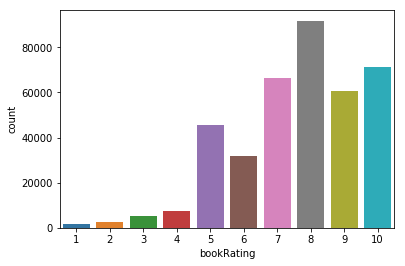

In [22]:
# This shows the no of times each rating (1 to 10) have been rated
sns.countplot(data=ratings_explicit , x='bookRating')
plt.show()

In [23]:
# Assigning threshold for the number of users that have rated books and also for the number of books that have been rated by users
# Users who have rated at least 15 books and the books that have been rated at least 15 users are selected

counts1 = ratings_explicit['userID'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['userID'].isin(counts1[counts1 >= 15].index)]
counts = ratings_explicit['bookRating'].value_counts()
ratings_explicit = ratings_explicit[ratings_explicit['bookRating'].isin(counts[counts >= 15].index)]
ratings_explicit.shape


# Data preprocessing up to here!!

(237088, 3)

In [0]:
# Before training the model through matrix factorization, the data (ratings_explicit) is to be spitted into training and testing sets
# This function returns training and test sets along with the raw dataframe for later evaluation of the model 

def informed_train_test(rating_df, train_ratio):
    split_cut = np.int(np.round(rating_df.shape[0] * train_ratio))
    train_df = rating_df.iloc[0:split_cut]
    test_df = rating_df.iloc[split_cut::]
    test_df = test_df[(test_df['userID'].isin(train_df['userID'])) & (test_df['ISBN'].isin(train_df['ISBN']))]
    id_cols = ['userID', 'ISBN']
    trans_cat_train = dict()
    trans_cat_test = dict()
    for k in id_cols:
        cate_enc = preprocessing.LabelEncoder()
        trans_cat_train[k] = cate_enc.fit_transform(train_df[k].values)
        trans_cat_test[k] = cate_enc.transform(test_df[k].values)

    # --- Encode ratings:
    cate_enc = preprocessing.LabelEncoder()
    ratings = dict()
    ratings['train'] = cate_enc.fit_transform(train_df.bookRating)
    ratings['test'] = cate_enc.transform(test_df.bookRating)

    n_users = len(np.unique(trans_cat_train['userID']))
    n_items = len(np.unique(trans_cat_train['ISBN']))


    train = coo_matrix((ratings['train'], (trans_cat_train['userID'], \
                                                          trans_cat_train['ISBN'])) \
                                      , shape=(n_users, n_items))
    test = coo_matrix((ratings['test'], (trans_cat_test['userID'], \
                                                        trans_cat_test['ISBN'])) \
                                     , shape=(n_users, n_items))
    return train, test, train_df

In [25]:
# Fitting the model
train, test, raw_train_df = informed_train_test(ratings_explicit, 0.8)

# Evaluating the model
start_time = time.time()
model=LightFM(no_components=115,learning_rate=0.027,loss='warp')
model.fit(train,epochs=12,num_threads=4)
# with open('saved_model','wb') as f:
#     saved_model={'model':model}
#     pickle.dump(saved_model, f)
auc_train = auc_score(model, train).mean()
auc_test = auc_score(model, test).mean()

print("--- Run time:  {} mins ---".format((time.time() - start_time)/60))
print("Train AUC Score: {}".format(auc_train))
print("Test AUC Score: {}".format(auc_test))

--- Run time:  2.360828713575999 mins ---
Train AUC Score: 0.9782722592353821
Test AUC Score: 0.9169355630874634


In [26]:
# Generating user-item rating matrix

user_item_matrix = raw_train_df.pivot(index='userID', columns='ISBN', values='bookRating')
user_item_matrix.fillna(0, inplace = True)
user_item_matrix = user_item_matrix.astype(np.int32)
print(user_item_matrix.shape)
user_item_matrix.head()

(3519, 98561)


ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B0000T6KHI,B0000T6KIM,B0000VZEJQ,B0000X8HIE,B00011SOXI,B00013AX9E,B0001FZGRQ,B0001GMSV2,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
242,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
243,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
254,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
388,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
503,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
# This function generates user and item dictionaries

def user_item_dikts(interaction_matrix, items_df):
    user_ids = list(interaction_matrix.index)
    user_dikt = {}
    counter = 0 
    for i in user_ids:
        user_dikt[i] = counter
        counter += 1

    item_dikt ={}
    for i in range(items_df.shape[0]):
        item_dikt[(items_df.loc[i,'ISBN'])] = items_df.loc[i,'bookTitle']
    
    return user_dikt, item_dikt



In [0]:
# This function generates top 15 recommendations for the user based on his/her interaction

def similar_recommendation(model, interaction_matrix, user_id, user_dikt, 
                               item_dikt,threshold = 0,number_rec_items = 15):

    #Function to produce user recommendations

    n_users, n_items = interaction_matrix.shape
    user_x = user_dikt[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interaction_matrix.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))
    
    known_items = list(pd.Series(interaction_matrix.loc[user_id,:][interaction_matrix.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    
    scores = [x for x in scores if x not in known_items]
    score_list = scores[0:number_rec_items]
    known_items = list(pd.Series(known_items).apply(lambda x: item_dikt[x]))
    scores = list(pd.Series(score_list).apply(lambda x: item_dikt[x]))

    print("Items that were liked by the User:")
    counter = 1
    for i in known_items[:25]:
        print(str(counter) + '- ' + i)
        counter+=1

    print("\n Recommended Items:")
    counter = 1
    for i in scores:
        print(str(counter) + '- ' + i)
        counter+=1
#     return score_list

In [0]:
user_dikt, item_dikt = user_item_dikts(user_item_matrix, books)

In [30]:
similar_recommendation(model, user_item_matrix, 503, user_dikt, item_dikt,threshold = 7)

Items that were liked by the User:
1- A Child Called \It\": One Child's Courage to Survive"
2- Chaos, Creativity, and Cosmic Consciousness
3- Genograms
4- The Age of Manipulation: The Con in Confidence, the Sin in Sincere
5- Angela's Ashes: A Memoir
6- The Gingerbread Man
7- The How to Think Like Leonardo da Vinci Workbook : Your Personal Companion to How to Think Like Leonardo da Vinci
8- Persuader
9- Adventures of Tom Sawyer
10- Personality Types : Using the Enneagram for Self-Discovery
11- Traveling Mercies: Some Thoughts on Faith
12- Desire of the Everlasting Hills: The World Before and After Jesus (Hinges of History (Paper), Vol 3)
13- Lord Foul's Bane (The Chronicles of Thomas Covenant the Unbeliever, Book 1)
14- The Liar's Club: A Memoir

 Recommended Items:
1- To Kill a Mockingbird
2- Interview with the Vampire
3- The Red Tent (Bestselling Backlist)
4- Jurassic Park
5- Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
6- The Joy Luck Club
7- Fahrenheit 451
8- A P